In [2]:
import pandas as pd # Utilisé pour la manipulation et l'analyse des données.
import networkx as nx
import random # pour la reproductibilité.
from Bio import SeqIO # Pour la manipulation de séquences biologiques.
import numpy as np # Pour les opérations numériques et le calcul scientifique.
import itertools # Pour les itérations.
from collections import Counter # Afin de calculer la fréquence des k-mers.
import matplotlib.pyplot as plt # Pour la visualisation de données.
import seaborn as sns # Egalement pour la visualisation de données.
from sklearn.metrics import pairwise_distances_argmin_min # Scikit-learn Pour l'application des algorithmes de machine learning, y compris K-means, ACP, t-SNE, ANOVA, et la régression logistique.
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV # Pour l'optimisaition des hyperparamètres.
from sklearn.cluster import KMeans # Pour la clusterisation
from sklearn.manifold import TSNE # Pour la réduction de dimensionnalité
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split # Pour l'implémentation de la régression logistique.
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from node2vec import Node2Vec
from gensim.models import Word2Vec #Pour l'implémentation de Word2Vec
import os

In [3]:
def lire_fasta(fichier):
    """
    Permet de lire un fichier FASTA et d'extraire les informations nécessaires.

    Args:
        fichier (str): Chemin du fichier FASTA à lire.

    Returns:
        list: Liste de dictionnaires contenant les informations extraites.
    """
    recs=list(SeqIO.parse(fichier, "fasta"))
    data=[]
    for rec in recs :
        accessions=os.path.basename(fichier).replace(".fasta", "")
        sequence=str(rec.seq)
        espece='eiav'
        taxon='11665'
        # Création des colonnes
        data.append({
            "accessions" : accessions,
            "taxon" : taxon,
            "especes" : espece,
            "sequences" : sequence,
            "taille" : len(sequence)
        })     
    return data

def tout_les_fasta(dossier):
    """
    Permet de parcourir un dossier contenant des fichiers FASTA et de consolider toutes les données dans un DataFrame.

    Argument:
        dossier (str): Chemin du dossier contenant les fichiers FASTA.

    Retourne : 
        Une DataFrame contenant toutes les données des fichiers FASTA.
    """
    dataframe=[]
    for fichier in os.listdir(dossier):
        if fichier.endswith(".fasta"):
            chemin_fichier=os.path.join(dossier, fichier)
            fichier_data = lire_fasta(chemin_fichier)
            dataframe.extend(fichier_data)               
    df=pd.DataFrame(dataframe)
    return df

# Chemin pour acceder aux fichiers FASTA
dossier_fasta = os.path.join(os.path.expanduser("~"), "Desktop", "Vrai Stage", "EIAV") # Chemin pour acceder aux fichiers

df=tout_les_fasta(dossier_fasta)

In [4]:
k=3

random.seed(111)
np.random.seed(111)
def remplace_ambiguite(sequence):
    """
    Remplace les bases ambiguës dans une séquence par des bases correspondantes.

    Argument:
        sequence : Séquence nucléotidique avec des bases ambiguës.

    Retourne:
        Séquence avec les bases ambiguës remplacées.
    """ 
    remplacements = {
        'Y': 'CT',
        'R': 'AG',
        'S': 'GC',
        'W': 'AT',
        'K': 'GT',
        'M': 'AC',
        'B': 'CGT',
        'D': 'AGT',
        'H': 'ACT',
        'V': 'ACG',
    }

    def remplacer_base(base):
        if base in remplacements:
            return random.choice(remplacements[base])
        return base

    return ''.join(remplacer_base(base) for base in sequence)
    
def kmers(sequence, k): 
    """
    Fonction pour générer une liste de k-mers à partir d'une séquence.

    Argument :
        sequence : Séquence d'Adn.
        k : Taille des k-mers.

    Retourne:
        kmers_list: Liste de k-mers.
    """
    kmers_list=[sequence[i:i+k] for i in range(len(sequence)-k+1)]
    return kmers_list

def kmers_tot(df, k):
    """
    Fonction pour générer une liste de tous les k-mers pour chaque séquence.
    """
    return [kmers(sequence, k) for sequence in df['sequences']]


def freq(sequence):
    """
    Fonction pour calculer la fréquence des k-mers dans une séquence donnée.

    Argument:
        sequence : Séquence d'ADN.

    Retourne:
        dict: Dictionnaire des fréquences des k-mers.
    """
    kmers_list = kmers(sequence, k)
    tot_kmers = len(kmers_list)
    kmer_counts = Counter(kmers_list)
    kmer_freq = {kmer: count / tot_kmers for kmer, count in kmer_counts.items()}
    return kmer_freq

def silhouette(df_embeddings, emb_col):
    kmeans=KMeans(n_clusters=12, random_state=42, n_init=10)
    df_embeddings['cluster']=kmeans.fit_predict(df_embeddings[emb_col])
    silhouette=silhouette_score(df_embeddings[emb_col], df_embeddings['cluster'])
    return silhouette
    
df['kmers']=kmers_tot(df, k=3) # Générer la liste des k-mers pour chaque séquence dans le dataframe
df['unique_kmers']=df['kmers'].apply(lambda kmers: len(set(kmers))) # Calculer le nombre de k-mers uniques pour chaque séquence
df['frequences']=df['sequences'].apply(freq) # ajoute la frequence a la dataframe
# Filtrer les séquences selon le nombre de k-mers uniques
all_kmers = [kmer for sublist in df['kmers'].tolist() for kmer in sublist]
#df = df.reset_index(drop=True)
#df.to_csv('df.csv', index=True)
df.tail()

,accessions,taxon,especes,sequences,taille,kmers,unique_kmers,frequences
4043,AY522781.1,11665,eiav,ATGGTCAGCATCGCATTCTATGGGGGGATCCCAGGGGGAATCTCAA...,891,"[ATG, TGG, GGT, GTC, TCA, CAG, AGC, GCA, CAT, ...",64,"{'ATG': 0.02699662542182227, 'TGG': 0.02474690..."
4044,AF429320.1,11665,eiav,ATGGTCAACATCGCATTCTATGGGGGGATCCCAGGGGGAATCTCAA...,1290,"[ATG, TGG, GGT, GTC, TCA, CAA, AAC, ACA, CAT, ...",64,"{'ATG': 0.02251552795031056, 'TGG': 0.02018633..."
4045,MK279163.1,11665,eiav,GCAGTACAGTTGAAGGAGAACAGCAGTAACATTATCATGAATAATT...,339,"[GCA, CAG, AGT, GTA, TAC, ACA, CAG, AGT, GTT, ...",59,"{'GCA': 0.01483679525222552, 'CAG': 0.02670623..."
4046,MK279173.1,11665,eiav,GCAGTACAGTTGAAGGAGAACAGCAGTAACATTATAATGAATAATT...,339,"[GCA, CAG, AGT, GTA, TAC, ACA, CAG, AGT, GTT, ...",59,"{'GCA': 0.01483679525222552, 'CAG': 0.02967359..."
4047,AF429330.1,11665,eiav,ATGGTCAGCATCGCATTCTATGGGGGGATCCCAGGGGGAATCTCAA...,1290,"[ATG, TGG, GGT, GTC, TCA, CAG, AGC, GCA, CAT, ...",64,"{'ATG': 0.023291925465838508, 'TGG': 0.0209627..."


In [5]:
random.seed(111)
np.random.seed(111)
sequences_list = df['sequences'].apply(list)

random.seed(111)
np.random.seed(111)

# Prendre les k-mers des séquences
all_kmers = df['kmers'].tolist()
model = Word2Vec(sentences=df['kmers'], vector_size=64, window=10, min_count=2, sg=1, seed=111)

# Obtenir les embeddings des k-mers
def get_kmer(kmer, model):
    try:
        return model.wv[kmer]
    except KeyError:
        return np.zeros(model.vector_size)  # En cas de k-mer absent dans le modèle

df['embedding'] = df['kmers'].apply(lambda x: np.mean([get_kmer(kmer, model) for kmer in x], axis=0))


In [6]:
# Préparer les données pour le clustering
X = np.array(df['embedding'].tolist())

# Nombre de clusters
n = 12

# Initialiser et ajuster le modèle KMeans
kmeans = KMeans(n_clusters=n, random_state=111)
df['cluster'] = kmeans.fit_predict(X)

# Réduire les dimensions avec PCA
pca = PCA(n_components=3, random_state=111)
pca_result = pca.fit_transform(X)
df['pca1'] = pca_result[:, 0]
df['pca2'] = pca_result[:, 1]
df['pca3'] = pca_result[:, 2]

tsne=TSNE(n_components=2, random_state=42, learning_rate='auto',
         init='random', perplexity=3).fit_transform(X)

df['tsne1']=tsne[:, 0]
df['tsne2']=tsne[:, 1]

# Trouver les indices des points les plus proches des centroïdes
centroides = kmeans.cluster_centers_
indices_proches, _ = pairwise_distances_argmin_min(centroides, X)

# Obtenir les accessions les plus proches
accessions_proches = df['accessions'].iloc[indices_proches]

# Affichage des résultats
for i, accession in enumerate(accessions_proches):
    print(f"Cluster {i+1} - Séquence la plus proche: {accession}")



Cluster 1 - Séquence la plus proche: AY522829.1
Cluster 2 - Séquence la plus proche: MG882250.1
Cluster 3 - Séquence la plus proche: AF314303.1
Cluster 4 - Séquence la plus proche: U35217.1
Cluster 5 - Séquence la plus proche: MH540751.1
Cluster 6 - Séquence la plus proche: BD226391.1
Cluster 7 - Séquence la plus proche: KF977803.1
Cluster 8 - Séquence la plus proche: HQ009194.1
Cluster 9 - Séquence la plus proche: JX480662.1
Cluster 10 - Séquence la plus proche: U01863.1
Cluster 11 - Séquence la plus proche: MK278950.1
Cluster 12 - Séquence la plus proche: AY288551.1


In [7]:
# Sélection des lignes correspondant aux 12 accessions les plus proches des centroïdes
df_12_accessions = df[df['accessions'].isin(accessions_proches)].copy()
# Suppression des doublons
colonnes_a_supprimer = ['kmers', 'unique_kmers', 'taille', 'frequences', 'cluster', 'embedding', 'pca1', 'pca2', 'pca3']  # Exemple, ajustez selon vos besoins
# Suppression des colonnes spécifiées
embedding_df = pd.DataFrame(df['embedding'].tolist(), columns=[f'emb_{i+1}' for i in range(df_12_accessions['embedding'].iloc[0].shape[0])])
df_12_accessions = pd.concat([df_12_accessions, embedding_df], axis=1)
df_12_accessions.drop(columns=colonnes_a_supprimer, inplace=True)
df_12_accessions.dropna(inplace=True)

df_12_accessions.drop_duplicates(subset='accessions', keep='first', inplace=True)
df_12_accessions.to_csv('df_12_accessions_SIV.csv', index=False)
df_12_accessions

,accessions,taxon,especes,sequences,tsne1,tsne2,emb_1,emb_2,emb_3,emb_4,...,emb_55,emb_56,emb_57,emb_58,emb_59,emb_60,emb_61,emb_62,emb_63,emb_64
79,AY288551.1,11665,eiav,TGCTGGGGTTCCTTCCCGGGGTGTAGACCATTTCAAAATTACTTCA...,18.959578,-93.237823,-0.030542,0.060842,0.180380,-0.101476,...,-0.314409,-0.011710,-0.176686,0.095139,0.035716,-0.070737,0.180384,-0.032408,0.035166,0.132211
959,BD226391.1,11665,eiav,AACAAAGGGAGGGA,12.470196,-70.512138,0.033666,0.079944,0.214650,-0.128825,...,-0.261322,0.069723,-0.261073,0.061325,0.030942,-0.134411,0.296027,-0.098836,0.112683,0.098435
1045,U01863.1,11665,eiav,CTAAACCGCAAAGATGTAGTTTCTCAATATAGTTCCGCATTTGTGA...,39.896919,80.498474,0.012301,0.076050,0.122589,-0.075211,...,-0.339836,-0.005424,-0.197972,0.109804,0.042369,-0.046061,0.097708,-0.021090,0.002768,0.114173
1174,MK278950.1,11665,eiav,GCAGTACAGTTGGAGAAGAACAGCAATAACATTATAATGAATAATT...,53.494179,-19.678297,-0.009238,0.074987,0.174548,-0.113646,...,-0.320402,-0.011994,-0.178973,0.104136,0.044496,-0.088965,0.171403,-0.024382,0.034850,0.147969
1287,HQ009194.1,11665,eiav,ATGGGATTATTTGGTAAAGGGGTAACATGGTCAGCATTGCATTCTA...,-12.288665,-4.228806,-0.031308,0.065474,0.178972,-0.117409,...,-0.311495,-0.001415,-0.185309,0.094772,0.035714,-0.081727,0.187137,-0.027752,0.040032,0.139665
1345,AY522829.1,11665,eiav,ATGGTCAGCATCGCATTCTATGGGGGGATCCCAGGGGGAATCTCAA...,-40.595737,51.584690,-0.029632,0.059176,0.181789,-0.110834,...,-0.299691,-0.005619,-0.187578,0.090305,0.034728,-0.075344,0.190152,-0.035752,0.045903,0.129615
1756,AF314303.1,11665,eiav,GATCCTCAGGGCCCTCTGGAAAGTGACCAGTGGTGCAGGGTCCTCC...,26.792292,-13.565326,-0.051796,0.038864,0.185108,-0.101479,...,-0.264602,0.008189,-0.203711,0.063559,0.012694,-0.040278,0.227577,-0.042865,0.072098,0.104299
1879,U35217.1,11665,eiav,CCATTTCAAAATTACTTCAGTTATGAGACCAATAGAAGCATGCATA...,0.341617,69.203964,-0.018969,0.070795,0.181961,-0.115567,...,-0.319633,0.002439,-0.179922,0.098255,0.039561,-0.082181,0.174510,-0.029482,0.023998,0.132730
2152,JX480662.1,11665,eiav,GTGACATGGAGCAAAGCGCTCAAGAAGTTAGAGAAGGTGACGGTTC...,-42.920155,-15.001388,-0.038560,0.056914,0.178751,-0.117317,...,-0.293495,-0.000501,-0.193364,0.083296,0.028374,-0.070105,0.205580,-0.030396,0.059537,0.141351
2318,MG882250.1,11665,eiav,TGTGGGATTAATATAAGATTCTTATAAGTGAATATGAAAGTTGCTG...,27.718758,31.775185,-0.040323,0.038179,0.138473,-0.061697,...,-0.325264,-0.034328,-0.213752,0.112353,0.038237,-0.041356,0.141783,-0.011343,0.010717,0.112269


In [8]:
required_columns = ['accessions', 'sequences', 'especes', 'embedding']

# Créez le DataFrame dataf avec les colonnes nécessaires
dataf = df[required_columns].copy()
colonnes_a_supprimer = ['embedding']  # Exemple, ajustez selon vos besoins
# Suppression des colonnes spécifiées
embeddings_df = pd.DataFrame(df['embedding'].tolist(), columns=[f'emb_{i+1}' for i in range(dataf['embedding'].iloc[0].shape[0])])
dataf = pd.concat([dataf, embeddings_df], axis=1)
dataf.drop(columns=colonnes_a_supprimer, inplace=True)
dataf.dropna(inplace=True)

dataf.drop_duplicates(subset='accessions', keep='first', inplace=True)
dataf.to_csv('dataframe_FIV.csv', index=False)
dataf

,accessions,sequences,especes,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,...,emb_55,emb_56,emb_57,emb_58,emb_59,emb_60,emb_61,emb_62,emb_63,emb_64
0,JX480714.1,AATGGAGGTTATTGCAAGATTTGAGAGAATTAAACAAAATGGTAGA...,eiav,-0.022416,0.072688,0.187819,-0.131158,-0.029888,-0.142867,0.082275,...,-0.306670,0.000114,-0.179897,0.097174,0.043712,-0.084790,0.194528,-0.039549,0.053216,0.155014
1,GQ202612.1,GCCACTCTGTTAGATGCTTATCAAAGAGAAATAACAAACATATACA...,eiav,-0.022216,0.068234,0.178052,-0.115977,-0.015011,-0.153237,0.086799,...,-0.318123,-0.006019,-0.188117,0.102261,0.036183,-0.086834,0.178393,-0.026047,0.035151,0.150716
2,AF298683.1,GTTCCTTCCCGGGGTGTAGACCATTTCAAAATTACTTCAGTTATGA...,eiav,-0.022372,0.067114,0.181214,-0.115703,-0.033159,-0.147079,0.087193,...,-0.315715,0.002247,-0.182783,0.096317,0.038507,-0.080747,0.174142,-0.030134,0.024931,0.131011
3,MK268254.1,ATGGTCAGCATTGCATTCTATGGGGATATCCCAGGGGGAATATCAA...,eiav,-0.030904,0.068129,0.179416,-0.118813,-0.021001,-0.143628,0.082010,...,-0.314441,-0.002016,-0.179946,0.093701,0.035218,-0.082241,0.189341,-0.027854,0.040487,0.144551
4,AF298693.1,GTTCCTTCCCGGGGTGTAGACCATTTCAAAATTACTTCAGTTATGA...,eiav,-0.025770,0.068585,0.180398,-0.116544,-0.030653,-0.146169,0.088628,...,-0.318785,0.002499,-0.180117,0.094644,0.036671,-0.080122,0.174509,-0.026835,0.027823,0.133443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4043,AY522781.1,ATGGTCAGCATCGCATTCTATGGGGGGATCCCAGGGGGAATCTCAA...,eiav,-0.030520,0.058621,0.181850,-0.110152,-0.035333,-0.137843,0.088868,...,-0.299285,-0.005885,-0.187381,0.090194,0.033545,-0.074405,0.191809,-0.035850,0.045831,0.129598
4044,AF429320.1,ATGGTCAACATCGCATTCTATGGGGGGATCCCAGGGGGAATCTCAA...,eiav,-0.030051,0.064112,0.182124,-0.117184,-0.030863,-0.137603,0.084776,...,-0.306044,0.000088,-0.182398,0.093651,0.037024,-0.077811,0.188164,-0.034177,0.040857,0.133788
4045,MK279163.1,GCAGTACAGTTGAAGGAGAACAGCAGTAACATTATCATGAATAATT...,eiav,-0.020785,0.066071,0.177439,-0.111032,-0.028197,-0.148400,0.087416,...,-0.310029,-0.006224,-0.188162,0.100270,0.039065,-0.077239,0.171467,-0.025201,0.034584,0.140292
4046,MK279173.1,GCAGTACAGTTGAAGGAGAACAGCAGTAACATTATAATGAATAATT...,eiav,-0.006885,0.073240,0.175492,-0.109176,-0.024152,-0.155541,0.084299,...,-0.318031,-0.011830,-0.178982,0.100211,0.040834,-0.085704,0.171161,-0.024425,0.032876,0.142707


Nombre de composantes principales nécessaires pour expliquer 90.0% de la variance : 5


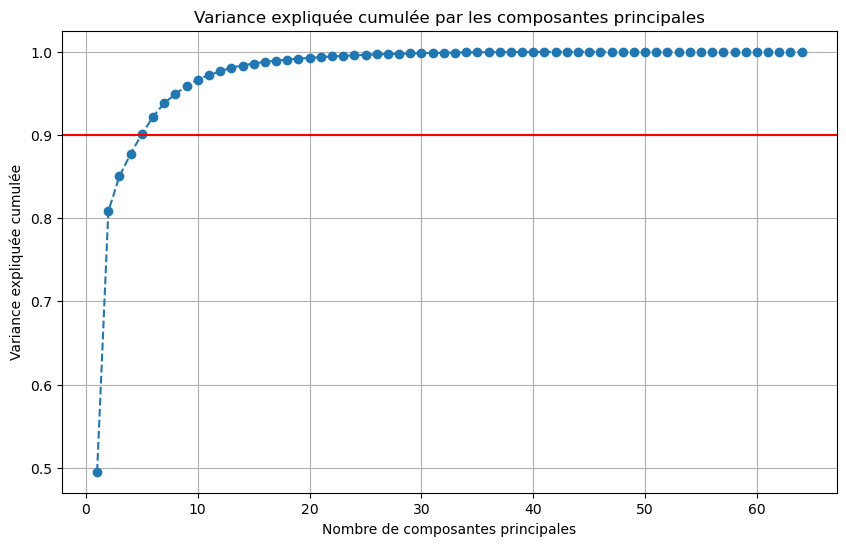

In [9]:
kmer_columns = [col for col in dataf.columns if col not in ['accessions', 'sequences', 'especes', 'soustype']]
X = dataf[kmer_columns].values

# Standardiser les données (important pour PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Appliquer PCA
pca = PCA()
pca.fit(X_scaled)

# Calculer la variance expliquée cumulée
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Trouver le nombre minimum de composantes principales pour un niveau de variance expliqué
def minimum_components_for_variance(variance_threshold=0.95):
    """
    Trouver le nombre minimum de composantes principales pour expliquer un certain niveau de variance.
    """
    for i, variance in enumerate(cumulative_variance):
        if variance >= variance_threshold:
            return i + 1
    return len(cumulative_variance)  # Retourne le nombre total de composantes si le seuil n'est pas atteint

variance_exp = 0.90
num_components = minimum_components_for_variance(variance_exp)

print(f"Nombre de composantes principales nécessaires pour expliquer {variance_exp*100}% de la variance : {num_components}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=variance_exp, color='r', linestyle='-')
plt.title('Variance expliquée cumulée par les composantes principales')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance expliquée cumulée')
plt.grid(True)
plt.show()

In [10]:
n_components = 16

# Obtenir les charges des k-mers pour les premières composantes principales
components = pca.components_[:num_components]  # Composantes principales
explained_variance_ratio = pca.explained_variance_ratio_[:num_components]  # Variance expliquée par chaque composante

# Afficher les charges pour les premières composantes principales
for i in range(num_components):
    print(f"\nComposante Principale {i+1} (Variance expliquée : {explained_variance_ratio[i]*100:.2f}%):")
    # Obtenir les indices des k-mers les plus importants pour cette composante
    top_indices = np.argsort(np.abs(components[i]))[-10:]  # Les 10 k-mers les plus importants
    top_kmers = [kmer_columns[idx] for idx in top_indices]
    top_charges = [components[i][idx] for idx in top_indices]
    
    # Afficher les k-mers les plus importants pour cette composante
    sorted_kmers = sorted(zip(top_kmers, top_charges), key=lambda x: -abs(x[1]))
    for kmer, charge in sorted_kmers:
        print(f"{kmer}: {charge:.4f}")



Composante Principale 1 (Variance expliquée : 49.53%):
emb_46: 0.1752
emb_43: -0.1730
emb_18: -0.1725
emb_8: 0.1723
emb_17: -0.1714
emb_11: 0.1677
emb_7: 0.1664
emb_3: -0.1663
emb_61: -0.1656
emb_48: 0.1654

Composante Principale 2 (Variance expliquée : 31.28%):
emb_15: 0.2033
emb_26: 0.1983
emb_49: -0.1890
emb_64: -0.1841
emb_5: -0.1828
emb_34: 0.1818
emb_60: 0.1809
emb_2: -0.1792
emb_32: 0.1780
emb_12: -0.1750

Composante Principale 3 (Variance expliquée : 4.25%):
emb_39: 0.3295
emb_1: 0.3217
emb_50: 0.3171
emb_24: -0.3022
emb_13: -0.2831
emb_51: 0.2667
emb_14: 0.2610
emb_31: -0.1733
emb_49: 0.1592
emb_44: 0.1562

Composante Principale 4 (Variance expliquée : 2.70%):
emb_13: 0.3969
emb_38: 0.3308
emb_23: 0.2999
emb_32: -0.2974
emb_54: 0.2711
emb_25: 0.2338
emb_49: -0.2232
emb_10: 0.2215
emb_62: 0.1653
emb_64: 0.1648

Composante Principale 5 (Variance expliquée : 2.35%):
emb_51: 0.4025
emb_39: -0.2527
emb_41: 0.2332
emb_30: 0.2215
emb_31: 0.2214
emb_56: 0.2052
emb_37: 0.2039
emb_42: 

In [11]:
# Obtenir les charges des k-mers pour les CP conservées
pca_components = pca.components_[:n_components]

# Créer un DataFrame des charges pour chaque k-mer
component_df = pd.DataFrame(pca_components.T, columns=[f'PC{i+1}' for i in range(n_components)], index=dataf.drop(columns=['accessions', 'sequences', 'especes']).columns)

# Calculer la moyenne des charges pour chaque k-mer
component_df['mean'] = component_df.abs().mean(axis=1)


# Trier les k-mers par leur importance moyenne (plus élevé est mieux)
top_kmers = component_df.sort_values(by='mean', ascending=False)

# Afficher les k-mers les plus représentatifs
print(top_kmers.head(16))  # Ajustez le nombre selon vos besoins


             PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
emb_39  0.034850  0.097363  0.329497  0.096869 -0.252690  0.146208  0.336224   
emb_13 -0.055902 -0.025625 -0.283125  0.396946  0.111391  0.422336 -0.258708   
emb_38  0.115564  0.041389 -0.126819  0.330846  0.181625 -0.325027  0.030078   
emb_27 -0.127691  0.110021 -0.073107  0.107398 -0.139059 -0.151727 -0.100006   
emb_51 -0.046847  0.128010  0.266746 -0.070649  0.402492  0.166658  0.058285   
emb_30  0.102016 -0.136657  0.096961 -0.081690  0.221493 -0.148691 -0.187129   
emb_41 -0.137375 -0.024290  0.084452  0.150852  0.233248 -0.220766  0.313411   
emb_23  0.104576  0.117119  0.124489  0.299946  0.151688  0.172669  0.170130   
emb_24 -0.020693 -0.162366 -0.302164  0.035655  0.093083  0.165748 -0.019036   
emb_31 -0.121224 -0.093724 -0.173280 -0.116903  0.221400  0.186191 -0.066414   
emb_14 -0.067013  0.145751  0.261005  0.087055  0.010876 -0.083638 -0.216461   
emb_40  0.103937 -0.136483  0.007527 -0.

In [13]:
def vect(df, dimensions=64, walk_length=30, num_walks=200, workers=4):
    G = nx.Graph()
    for _, row in df.iterrows():
        G.add_node(row["accessions"], sequence=row["sequences"], espece=row["especes"], kmers=row["kmers"])

    node2vec = Node2Vec(G, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, workers=workers)
    walks = node2vec.walks
    model = Word2Vec(sentences=walks, vector_size=dimensions, window=10, min_count=1, workers=workers)

    embeddings = {node: model.wv[node] for node in model.wv.index_to_key}
    df_embeddings = pd.DataFrame(embeddings.values(), index=embeddings.keys())
    df_embeddings.columns = [f"emb_{i+1}" for i in range(len(df_embeddings.columns))]

    df_embeddings.reset_index(inplace=True)
    df_embeddings.rename(columns={'index': 'accessions'}, inplace=True)
    df_embeddings = df_embeddings.merge(df[['accessions', 'especes', 'taxon']], on='accessions', how='left')

    return df_embeddings

# Utilisation
df1 = vect(df, dimensions=64, walk_length=30, num_walks=200, workers=4)

#random.seed(1234)
emb_col = [f'emb_{i+1}' for i in range(64)]
kmeans=KMeans(n_clusters=12, random_state=42, n_init=10)

df1['cluster'] = kmeans.fit_predict(df1[emb_col])

tsne=TSNE(n_components=2, random_state=42, learning_rate='auto',
         init='random', perplexity=3).fit_transform(df1[emb_col])

df1['tsne1']=tsne[:, 0]
df1['tsne2']=tsne[:, 1]
centroides = kmeans.cluster_centers_
points_proche, _ = pairwise_distances_argmin_min(centroides, df1[emb_col])
accessions_proche = df1.loc[points_proche, 'accessions'].values

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df1[emb_col])
df1['pca1'] = pca_result[:, 0]
df1['pca2'] = pca_result[:, 1]


for i, accession in enumerate(accessions_proche):
    print(f"Cluster {i+1} - Séquence la plus proche: {accession}")

Computing transition probabilities: 100%|█| 4048/4048 [00:00<00:00, 272752.05it/
Generating walks (CPU: 4): 100%|██████████| 50/50 [00:01<00:00, 33.25it/s]


Cluster 1 - Séquence la plus proche: MK279273.1
Cluster 2 - Séquence la plus proche: AF005150.1
Cluster 3 - Séquence la plus proche: KY465018.1
Cluster 4 - Séquence la plus proche: HQ242679.1
Cluster 5 - Séquence la plus proche: JQ627095.1
Cluster 6 - Séquence la plus proche: MK174366.1
Cluster 7 - Séquence la plus proche: AF172103.1
Cluster 8 - Séquence la plus proche: AY524357.1
Cluster 9 - Séquence la plus proche: MK174366.1
Cluster 10 - Séquence la plus proche: AF005122.1
Cluster 11 - Séquence la plus proche: HQ242679.1
Cluster 12 - Séquence la plus proche: M87580.1


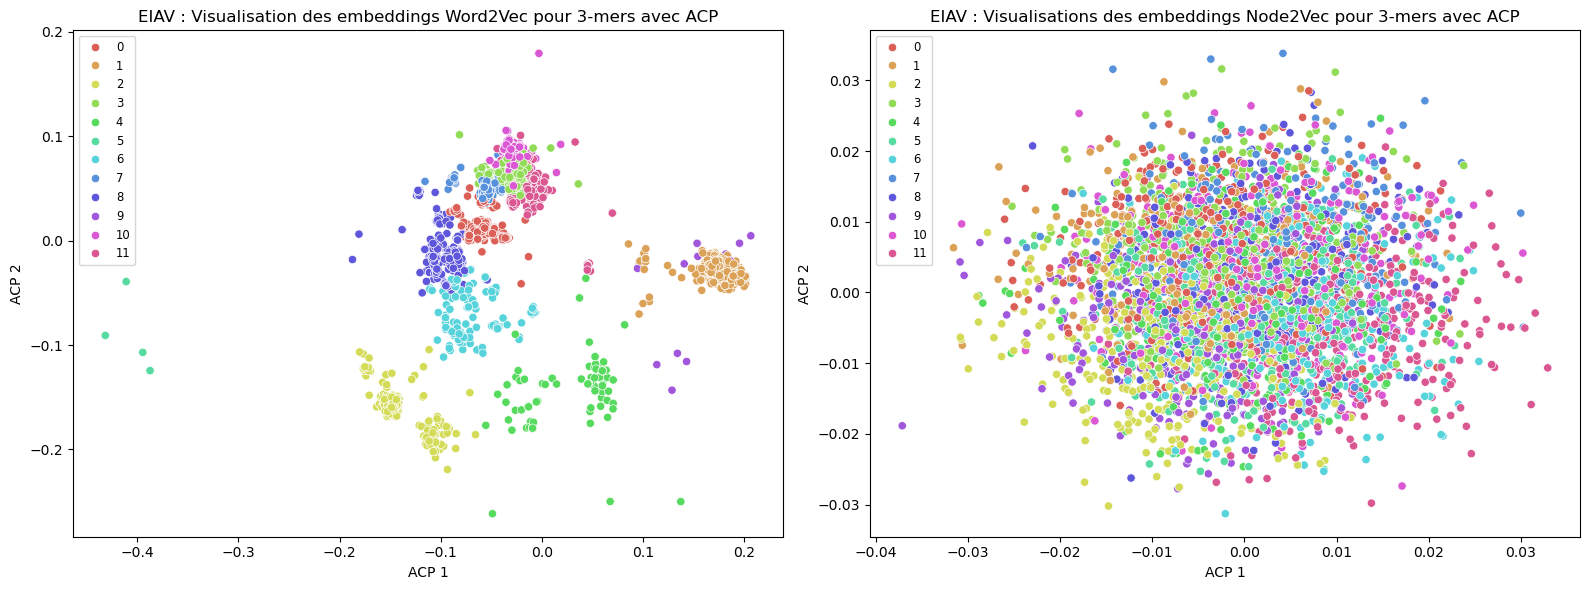

In [14]:
# Configuration de la taille de la figure
plt.figure(figsize=(16, 6))

# Premier subplot : Word2Vec
plt.subplot(1, 2, 1)
scatter = sns.scatterplot(data=df, x='pca1', y='pca2', hue='cluster', palette=sns.color_palette("hls", n), legend='full')
plt.title('EIAV : Visualisation des embeddings Word2Vec pour 3-mers avec ACP')
plt.xlabel('ACP 1')
plt.ylabel('ACP 2')
plt.legend(fontsize='small')

# Deuxième subplot : Node2Vec
plt.subplot(1, 2, 2)
sns.scatterplot(data=df1, x='pca1', y='pca2', hue='cluster', palette=sns.color_palette("hls", 12), legend='full')
plt.title('EIAV : Visualisations des embeddings Node2Vec pour 3-mers avec ACP')
plt.xlabel('ACP 1')
plt.ylabel('ACP 2')
plt.legend(fontsize='small')

# Sauvegarde et affichage de la figure
plt.tight_layout()
plt.savefig('acp_eiav_3mers.png', format='png')
plt.show()

# Clustering KMeans avec Node2Vec embeddings
emb_col = [f'emb_{i+1}' for i in range(64)]
kmeans = KMeans(n_clusters=12, random_state=42, n_init=10)
df1['cluster'] = kmeans.fit_predict(df1[emb_col])


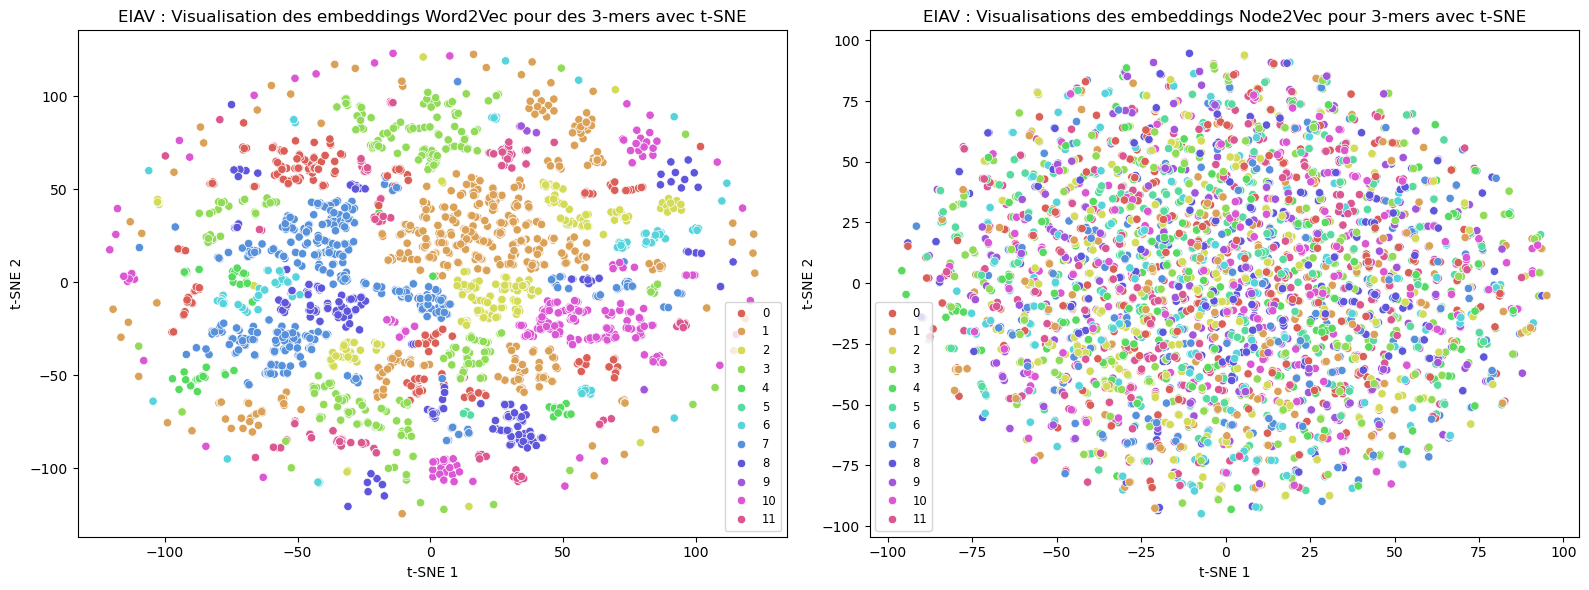

In [15]:
# Configuration de la taille de la figure
plt.figure(figsize=(16, 6))

# Premier subplot : Word2VEc
plt.subplot(1, 2, 1)
scatter = sns.scatterplot(data=df, x='tsne1', y='tsne2', hue='cluster', palette=sns.color_palette("hls", n), legend='full')
plt.title('EIAV : Visualisation des embeddings Word2Vec pour des 3-mers avec t-SNE')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(fontsize='small')

# Deuxième subplot : Node2Vec
plt.subplot(1, 2, 2)
sns.scatterplot(data=df1, x='tsne1', y='tsne2', hue='cluster', palette=sns.color_palette("hls", 12), legend='full')
plt.title('EIAV : Visualisations des embeddings Node2Vec pour 3-mers avec t-SNE')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(fontsize='small')

# Sauvegarde et affichage de la figure
plt.tight_layout()
plt.savefig('tsne_eiav_3mers.png', format='png')
plt.show()

# Clustering KMeans avec Node2Vec embeddings
emb_col = [f'emb_{i+1}' for i in range(64)]
kmeans = KMeans(n_clusters=12, random_state=42, n_init=10)
df1['cluster'] = kmeans.fit_predict(df1[emb_col])


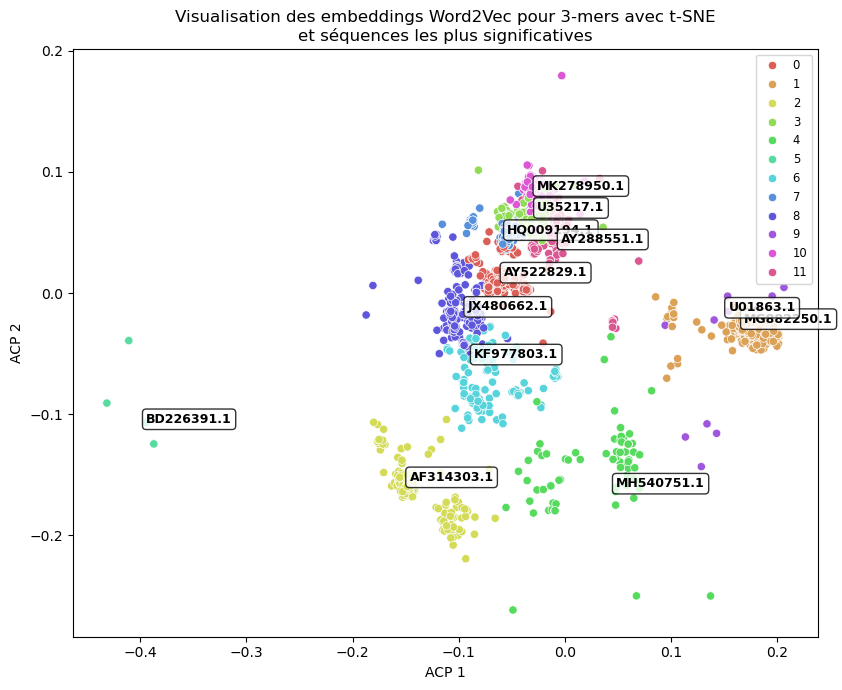

In [19]:
# Configuration de la taille de la figure
plt.figure(figsize=(9, 7))

# Affichage du scatter plot avec t-SNE
scatter = sns.scatterplot(data=df, x='pca1', y='pca2', hue='cluster', palette=sns.color_palette("hls", n), legend='full')

# Annoter les séquences les plus proches des centroïdes
for i, accession in enumerate(accessions_proches):
    # Obtenir les coordonnées t-SNE de chaque accession
    x = df.loc[df['accessions'] == accession, 'pca1'].values[0]
    y = df.loc[df['accessions'] == accession, 'pca2'].values[0]
    
    # Ajouter l'annotation sur le scatter plot
    scatter.annotate(accession, (x, y), fontsize=9, color='black', weight='bold',
                     bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.8))

plt.title('Visualisation des embeddings Word2Vec pour 3-mers avec t-SNE\net séquences les plus significatives')
plt.xlabel('ACP 1')
plt.ylabel('ACP 2')
plt.legend(fontsize='small', loc='best', bbox_to_anchor=(1, 1))

# Sauvegarde et affichage de la figure
plt.tight_layout()
plt.savefig('kmeans_3mers_eiav.png', format='png')
plt.show()

In [20]:
# Calcul du silhouette score Word2Vec
silhouette_w2v = silhouette_score(X, df['cluster'])
print(f"Silhouette Score moyen pour le clustering KMeans avec Word2Vec : {silhouette_w2v}")

# Calcul du silhouette score pour les embeddings Node2Vec
silhouette_n2v = silhouette_score(df1[emb_col], df1['cluster'])
print(f"Silhouette Score moyen pour le clustering KMeans avec Node2Vec : {silhouette_n2v}")


Silhouette Score moyen pour le clustering KMeans avec Word2Vec : 0.5260690034821341
Silhouette Score moyen pour le clustering KMeans avec Node2Vec : 0.011484354734420776
